## 기본 설정
1. 라이브러리 불러오기
2. 성능 평가 관련 함수 정의
3. basic 데이터 불러오기

In [3]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### 성능 평가 관련 함수 정의

In [4]:
def cf_maxtix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [5]:
def get_clf_eval(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 Score: {f1:.4f}')

### Basic 데이터 불러오기

In [6]:
path = '/content/drive/MyDrive/team_project1/data/Basic/'

In [7]:
X_train = pd.read_csv(path + "X_train.csv")
X_test = pd.read_csv(path + "X_test.csv")
X_val = pd.read_csv(path + "X_val.csv")

y_train = pd.read_csv(path + "y_train.csv")
y_test = pd.read_csv(path + "y_test.csv")
y_val = pd.read_csv(path + "y_val.csv")

X_train.shape, X_test.shape, X_val.shape

((10877, 8), (3400, 8), (2720, 8))

In [8]:
# train, val 데이터 합치기
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

X_train.shape, y_train.shape

((13597, 8), (13597, 1))

In [9]:
# 타겟데이터 비율 확인
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True), y_val.value_counts(normalize=True)

(target_class
 0               0.904096
 1               0.095904
 dtype: float64,
 target_class
 0               0.904118
 1               0.095882
 dtype: float64,
 target_class
 0               0.904044
 1               0.095956
 dtype: float64)

## Basic Data with GridSearchCV

### 로지스틱 회귀

In [8]:
lr = LogisticRegression()

In [9]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [0.5, 1, 3, 5],
              'max_iter':[100, 150, 200]}

In [10]:
grid = GridSearchCV(lr, param_grid, cv=5)

In [11]:
X_train.shape, X_test.shape

((13597, 8), (3400, 8))

In [12]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")

모델 학습 시간: 47.573784828186035


In [17]:
print(f"최적의 매개변수: {grid.best_params_}")

최적의 매개변수: {'C': 0.5, 'max_iter': 200, 'penalty': None}
최적 모델 성능: 0.9776421269397662


In [14]:
y_pred = grid.best_estimator_.predict(X_test)

In [23]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9774
test: 
정확도: 0.9809, 정밀도: 0.9547, 재현율: 0.8405, F1 Score: 0.8940


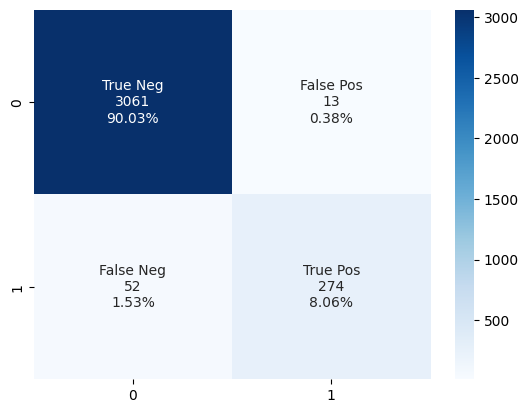

In [15]:
cf_maxtix(y_test, y_pred)

### LGBM

In [24]:
lgbm =  LGBMClassifier(objective='binary')

In [25]:
param_grid = {'max_depth': [3, 6, 9],
              'n_estimators': [100, 150, 200]}

In [26]:
grid = GridSearchCV(lgbm, param_grid, cv=5)

In [27]:
X_train.shape, X_test.shape

((13597, 8), (3400, 8))

In [28]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")

모델 학습 시간: 9.53935432434082


In [29]:
print(f"최적의 매개변수: {grid.best_params_}")

최적의 매개변수: {'max_depth': 6, 'n_estimators': 100}


In [30]:
y_pred = grid.best_estimator_.predict(X_test)

In [31]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9786
test: 
정확도: 0.9800, 정밀도: 0.9358, 재현율: 0.8497, F1 Score: 0.8907


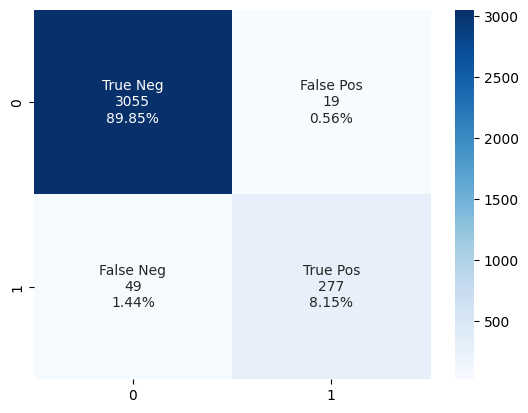

In [32]:
cf_maxtix(y_test, y_pred)

## Basic Data + Scaler with GridSearchCV

### 로지스틱 회귀

In [128]:
pipe = Pipeline([("preprocessing", MinMaxScaler()), ("classification", LogisticRegression())])

In [76]:
param_grid = {'preprocessing': [StandardScaler(), MinMaxScaler()],
              'classification__penalty': ['l1', 'l2', 'elasticnet', None],
              'classification__C': [0.5, 1, 3, 5],
              'classification__max_iter':[100, 150, 200]}

In [77]:
grid = GridSearchCV(pipe, param_grid, cv=5)

In [78]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")

모델 학습 시간: 19.65646743774414


In [79]:
# results = pd.DataFrame(grid.cv_results_)

# np.transpose(results.head(10))

In [80]:
print(f"최적의 매개변수: {grid.best_params_}")

최적의 매개변수: {'classification__C': 0.5, 'classification__max_iter': 100, 'classification__penalty': None, 'preprocessing': StandardScaler()}


In [81]:
y_pred = grid.best_estimator_.predict(X_test)

In [82]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9773
test: 
정확도: 0.9809, 정밀도: 0.9547, 재현율: 0.8405, F1 Score: 0.8940


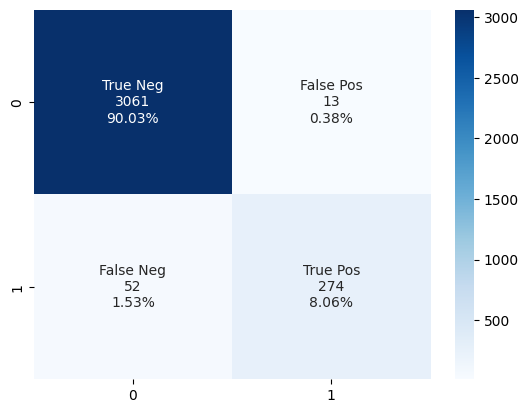

In [83]:
cf_maxtix(y_test, y_pred)

### LGBM

In [89]:
pipe = Pipeline([('preprocessing', None), ('classification', LGBMClassifier(objective='binary'))])

In [90]:
param_grid = { 'preprocessing': [StandardScaler(), MinMaxScaler()],
              'classification__max_depth': [3, 6, 9],
              'classification__n_estimators': [100, 150, 200]}

In [91]:
grid = GridSearchCV(pipe, param_grid, cv=5)

In [92]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")

모델 학습 시간: 21.952654361724854


In [93]:
print(f"최적의 매개변수: {grid.best_params_}")

최적의 매개변수: {'classification__max_depth': 6, 'classification__n_estimators': 100, 'preprocessing': StandardScaler()}


In [94]:
y_pred = grid.best_estimator_.predict(X_test)

In [95]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9785
test: 
정확도: 0.9794, 정밀도: 0.9384, 재현율: 0.8405, F1 Score: 0.8867


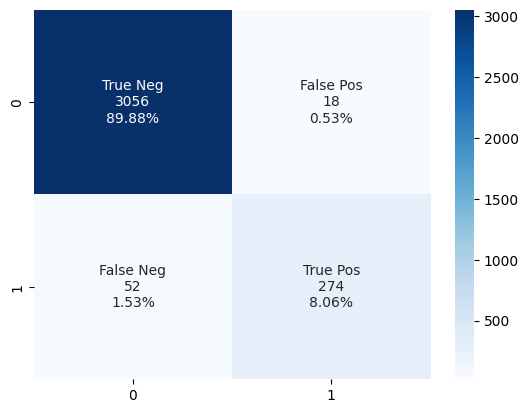

In [96]:
cf_maxtix(y_test, y_pred)

## Basic Data + Scaler + class_weight with GridSearchCV

### 로지스틱 회귀

In [84]:
pipe = Pipeline ([
    ('scale', StandardScaler()), 
    ('classification', LogisticRegression(class_weight='balanced')),
])

param_grid = {
              'classification__penalty': [None, 'elasticnet', 'l1', 'l2'],
              'classification__C': [0.5, 1, 3, 5],
              'classification__max_iter':[100, 150, 200]}

grid = GridSearchCV(pipe, param_grid, cv=5)

In [85]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")


모델 학습 시간: 9.438163995742798


In [86]:
print(f"최적의 매개변수: {grid.best_params_}")

최적의 매개변수: {'classification__C': 0.5, 'classification__max_iter': 100, 'classification__penalty': 'l2'}


In [87]:
y_pred = grid.best_estimator_.predict(X_test)

In [88]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9688
test: 
정확도: 0.9735, 정밀도: 0.8278, 재현율: 0.9141, F1 Score: 0.8688


### LGBM

In [103]:
pipe = Pipeline([('preprocessing', None), ('classification', LGBMClassifier(objective='binary', class_weight='balanced'))])

In [104]:
param_grid = { 'preprocessing': [StandardScaler(), MinMaxScaler()],
              'classification__max_depth': [3, 6, 9],
              'classification__n_estimators': [100, 150, 200]}

grid = GridSearchCV(pipe, param_grid, cv=5)

In [105]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")
print(f"최적의 매개변수: {grid.best_params_}")

모델 학습 시간: 22.617989540100098
최적의 매개변수: {'classification__max_depth': 9, 'classification__n_estimators': 200, 'preprocessing': MinMaxScaler()}


In [106]:
y_pred = grid.best_estimator_.predict(X_test)

In [107]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9772
test: 
정확도: 0.9785, 정밀도: 0.9016, 재현율: 0.8712, F1 Score: 0.8861


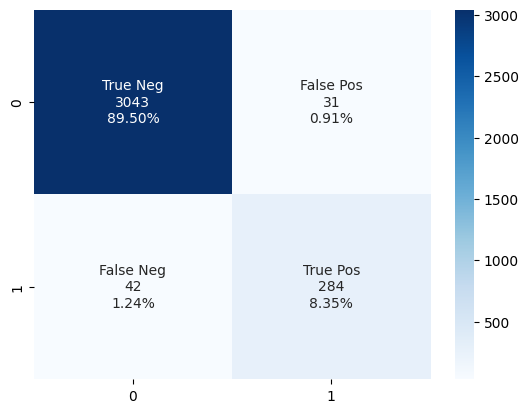

In [108]:
cf_maxtix(y_test, y_pred)

## Basic Data + Scaler + feature selection with GridSearchCV
-> 앞서 가장 좋은 성능을 보인 로지스틱 회귀로 테스트

### 타겟과의 상관관계가 낮은 feature들을 삭제

In [111]:
cols = [' Mean of the integrated profile',' Excess kurtosis of the integrated profile', ' Skewness of the integrated profile', ' Mean of the DM-SNR curve', ' Skewness of the DM-SNR curve']

X_train_new = X_train[cols]
X_test_new = X_test[cols]

X_train_new.shape, X_test_new.shape

((13597, 5), (3400, 5))

In [112]:
pipe = Pipeline([("preprocessing", MinMaxScaler()), ("classification", LogisticRegression())])

param_grid = {'preprocessing': [StandardScaler(), MinMaxScaler()],
              'classification__penalty': ['l1', 'l2', 'elasticnet', None],
              'classification__C': [0.5, 1, 3, 5],
              'classification__max_iter':[100, 150, 200]}
              
grid = GridSearchCV(pipe, param_grid, cv=5)

In [113]:
start = time.time()
grid.fit(X_train_new, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")
print(f"최적의 매개변수: {grid.best_params_}")

모델 학습 시간: 12.187877416610718
최적의 매개변수: {'classification__C': 0.5, 'classification__max_iter': 100, 'classification__penalty': None, 'preprocessing': StandardScaler()}


In [114]:
y_pred = grid.best_estimator_.predict(X_test_new)

In [115]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9770
test: 
정확도: 0.9806, 정밀도: 0.9610, 재현율: 0.8313, F1 Score: 0.8914


### feature들 중 상관관계가 높은 두 쌍의 변수들 중 각각 하나의 변수를 삭제

In [116]:
cols = [' Mean of the integrated profile', ' Standard deviation of the integrated profile',' Excess kurtosis of the integrated profile', ' Mean of the DM-SNR curve',' Standard deviation of the DM-SNR curve',' Excess kurtosis of the DM-SNR curve']

X_train_new = X_train[cols]
X_test_new = X_test[cols]

X_train_new.shape, X_test_new.shape

((13597, 6), (3400, 6))

In [117]:
pipe = Pipeline([("preprocessing", MinMaxScaler()), ("classification", LogisticRegression())])

param_grid = {'preprocessing': [StandardScaler(), MinMaxScaler()],
              'classification__penalty': ['l1', 'l2', 'elasticnet', None],
              'classification__C': [0.5, 1, 3, 5],
              'classification__max_iter':[100, 150, 200]}
              
grid = GridSearchCV(pipe, param_grid, cv=5)

In [118]:
start = time.time()
grid.fit(X_train_new, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")
print(f"최적의 매개변수: {grid.best_params_}")

모델 학습 시간: 12.512675762176514
최적의 매개변수: {'classification__C': 0.5, 'classification__max_iter': 100, 'classification__penalty': None, 'preprocessing': StandardScaler()}


In [119]:
y_pred = grid.best_estimator_.predict(X_test_new)

In [120]:
print(f"train 평균 accuarcy: ")
print(f"최적 모델 성능: {grid.best_score_:.4f}")
print(f"test: ")
get_clf_eval(y_test, y_pred)

train 평균 accuarcy: 
최적 모델 성능: 0.9765
test: 
정확도: 0.9788, 정밀도: 0.9536, 재현율: 0.8190, F1 Score: 0.8812


## Minmax + Standard + SMOTE with EarlyStoppings

In [10]:
path = '/content/drive/MyDrive/team_project1/data/Minmax+Standard/'

In [11]:
X_train = pd.read_csv(path + "X_train_MS_smote.csv")
X_test = pd.read_csv(path + "X_test_MS.csv")
X_val = pd.read_csv(path + "X_val_MS.csv")

y_train = pd.read_csv(path + "y_train_MS_smote.csv")
y_test = pd.read_csv(path + "y_test.csv")
y_val = pd.read_csv(path + "y_val.csv")

X_train.shape, X_test.shape, X_val.shape

((19668, 8), (3400, 8), (2720, 8))

In [13]:
watchlist = [(X_train, y_train), (X_val, y_val)]

### 로지스틱 회귀

In [9]:
lr = LogisticRegression(C=3, max_iter=100, penalty='l2')

In [10]:
X_train.shape, X_test.shape, X_val.shape

((19668, 8), (3400, 8), (2720, 8))

In [11]:
start = time.time()
lr.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")

모델 학습 시간: 0.06736612319946289


In [12]:
y_val_pred = lr.predict(X_val)
y_pred = lr.predict(X_test)

In [15]:
print(f"validation: ")
get_clf_eval(y_val, y_val_pred)
print(f"test: ")
get_clf_eval(y_test, y_pred)

validation: 
정확도: 0.9632, 정밀도: 0.7692, 재현율: 0.8812, F1 Score: 0.8214
test: 
정확도: 0.9706, 정밀도: 0.8038, 재현율: 0.9172, F1 Score: 0.8567


### LGBM

In [39]:
model = LGBMClassifier(
    objective='binary',
    eval_metric='auc',
    n_estimators=987654321,
    random_state=42,
    max_depth=6,
    learning_rate=0.05
)

In [40]:
start = time.time()
model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=50)
end = time.time()

print(f"모델 학습 시간: {end-start}")

[1]	training's binary_logloss: 0.651543	valid_1's binary_logloss: 0.652336
[2]	training's binary_logloss: 0.613843	valid_1's binary_logloss: 0.615211
[3]	training's binary_logloss: 0.579541	valid_1's binary_logloss: 0.581348
[4]	training's binary_logloss: 0.548235	valid_1's binary_logloss: 0.550324
[5]	training's binary_logloss: 0.519508	valid_1's binary_logloss: 0.521763
[6]	training's binary_logloss: 0.493145	valid_1's binary_logloss: 0.495801
[7]	training's binary_logloss: 0.468785	valid_1's binary_logloss: 0.471795
[8]	training's binary_logloss: 0.446304	valid_1's binary_logloss: 0.449512
[9]	training's binary_logloss: 0.425578	valid_1's binary_logloss: 0.429004
[10]	training's binary_logloss: 0.406311	valid_1's binary_logloss: 0.40987
[11]	training's binary_logloss: 0.388436	valid_1's binary_logloss: 0.392014
[12]	training's binary_logloss: 0.371812	valid_1's binary_logloss: 0.375471
[13]	training's binary_logloss: 0.356176	valid_1's binary_logloss: 0.359988
[14]	training's binary

In [41]:
y_pred = model.predict(X_test)

In [42]:
print(f"test: ")
get_clf_eval(y_test, y_pred)

test: 
정확도: 0.9732, 정밀도: 0.8386, 재현율: 0.8926, F1 Score: 0.8648


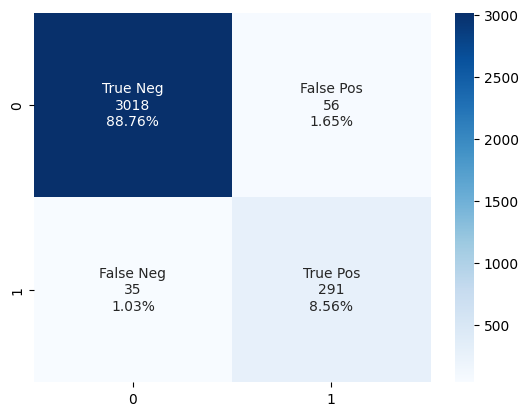

In [26]:
cf_maxtix(y_test, y_pred)

### XGB

In [30]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=987654321,
    random_state=42,
    max_depth=5,
    learning_rate=0.1
)

In [31]:
start = time.time()
model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=50)
end = time.time()

print(f"모델 학습 시간: {end-start}")

[0]	validation_0-auc:0.98345	validation_1-auc:0.96127
[1]	validation_0-auc:0.98489	validation_1-auc:0.96224
[2]	validation_0-auc:0.98528	validation_1-auc:0.96302
[3]	validation_0-auc:0.98600	validation_1-auc:0.96621
[4]	validation_0-auc:0.98744	validation_1-auc:0.96672
[5]	validation_0-auc:0.98763	validation_1-auc:0.96514
[6]	validation_0-auc:0.98777	validation_1-auc:0.96506
[7]	validation_0-auc:0.98789	validation_1-auc:0.96487
[8]	validation_0-auc:0.98817	validation_1-auc:0.96484
[9]	validation_0-auc:0.98828	validation_1-auc:0.96497
[10]	validation_0-auc:0.98863	validation_1-auc:0.96488
[11]	validation_0-auc:0.98881	validation_1-auc:0.96505
[12]	validation_0-auc:0.98909	validation_1-auc:0.96517
[13]	validation_0-auc:0.98938	validation_1-auc:0.96498
[14]	validation_0-auc:0.98949	validation_1-auc:0.96515
[15]	validation_0-auc:0.98959	validation_1-auc:0.96503
[16]	validation_0-auc:0.98986	validation_1-auc:0.96551
[17]	validation_0-auc:0.99013	validation_1-auc:0.96590
[18]	validation_0-au

In [32]:
y_pred = model.predict(X_test)

In [33]:
print(f"test: ")
get_clf_eval(y_test, y_pred)

test: 
정확도: 0.9750, 정밀도: 0.8453, 재현율: 0.9049, F1 Score: 0.8741


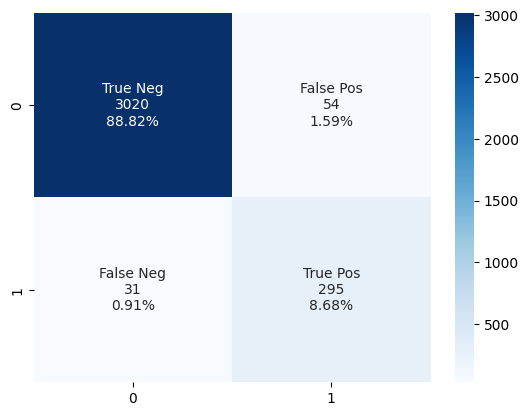

In [34]:
cf_maxtix(y_test, y_pred)

## Minmax + Standard + ADASYN with EarlyStoppings

In [43]:
path = '/content/drive/MyDrive/team_project1/data/Minmax+Standard/'

In [44]:
X_train = pd.read_csv(path + "X_train_MS_adasyn.csv")
X_test = pd.read_csv(path + "X_test_MS.csv")
X_val = pd.read_csv(path + "X_val_MS.csv")

y_train = pd.read_csv(path + "y_train_MS_adasyn.csv")
y_test = pd.read_csv(path + "y_test.csv")
y_val = pd.read_csv(path + "y_val.csv")

X_train.shape, X_test.shape, X_val.shape

((19607, 8), (3400, 8), (2720, 8))

In [45]:
watchlist = [(X_train, y_train), (X_val, y_val)]

### 로지스틱 회귀

In [23]:
lr = LogisticRegression(C=3, max_iter=100, penalty='l2')

In [24]:
X_train.shape

(19607, 8)

In [25]:
start = time.time()
lr.fit(X_train, y_train)
end = time.time()

print(f"모델 학습 시간: {end-start}")

모델 학습 시간: 0.08271169662475586


In [26]:
y_val_pred = lr.predict(X_val)
y_pred = lr.predict(X_test)

In [27]:
print(f"validation: ")
get_clf_eval(y_val, y_val_pred)
print(f"test: ")
get_clf_eval(y_test, y_pred)

validation: 
정확도: 0.8566, 정밀도: 0.3951, 재현율: 0.9310, F1 Score: 0.5548
test: 
정확도: 0.8718, 정밀도: 0.4257, 재현율: 0.9663, F1 Score: 0.5910


### LGBM

In [47]:
model = LGBMClassifier(
    objective='binary',
    eval_metric='auc',
    n_estimators=987654321,
    random_state=42,
    max_depth=6,
    learning_rate=0.05
)

In [48]:
start = time.time()
model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=50)
end = time.time()

print(f"모델 학습 시간: {end-start}")

[LightGBM] [Warning] Unknown parameter: eval_metric
[1]	training's binary_logloss: 0.662357	valid_1's binary_logloss: 0.659718
[2]	training's binary_logloss: 0.634478	valid_1's binary_logloss: 0.631519
[3]	training's binary_logloss: 0.608832	valid_1's binary_logloss: 0.606238
[4]	training's binary_logloss: 0.585871	valid_1's binary_logloss: 0.582729
[5]	training's binary_logloss: 0.56448	valid_1's binary_logloss: 0.561054
[6]	training's binary_logloss: 0.545063	valid_1's binary_logloss: 0.541193
[7]	training's binary_logloss: 0.526844	valid_1's binary_logloss: 0.522915
[8]	training's binary_logloss: 0.509089	valid_1's binary_logloss: 0.50537
[9]	training's binary_logloss: 0.493267	valid_1's binary_logloss: 0.489777
[10]	training's binary_logloss: 0.478043	valid_1's binary_logloss: 0.475216
[11]	training's binary_logloss: 0.464056	valid_1's binary_logloss: 0.461693
[12]	training's binary_logloss: 0.451181	valid_1's binary_logloss: 0.449205
[13]	training's binary_logloss: 0.438727	valid_

In [49]:
y_pred = model.predict(X_test)

In [50]:
print(f"test: ")
get_clf_eval(y_test, y_pred)

test: 
정확도: 0.9521, 정밀도: 0.6900, 재현율: 0.9080, F1 Score: 0.7841


### XGB

In [51]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=987654321,
    random_state=42,
    max_depth=5,
    learning_rate=0.1
)

In [52]:
start = time.time()
model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=50)
end = time.time()

print(f"모델 학습 시간: {end-start}")

[0]	validation_0-auc:0.93368	validation_1-auc:0.95532
[1]	validation_0-auc:0.94088	validation_1-auc:0.96108
[2]	validation_0-auc:0.94587	validation_1-auc:0.96275
[3]	validation_0-auc:0.94861	validation_1-auc:0.96458
[4]	validation_0-auc:0.94978	validation_1-auc:0.96387
[5]	validation_0-auc:0.95035	validation_1-auc:0.96365
[6]	validation_0-auc:0.95144	validation_1-auc:0.96335
[7]	validation_0-auc:0.95484	validation_1-auc:0.96405
[8]	validation_0-auc:0.95693	validation_1-auc:0.96485
[9]	validation_0-auc:0.95812	validation_1-auc:0.96538
[10]	validation_0-auc:0.95890	validation_1-auc:0.96568
[11]	validation_0-auc:0.95948	validation_1-auc:0.96608
[12]	validation_0-auc:0.96037	validation_1-auc:0.96703
[13]	validation_0-auc:0.96099	validation_1-auc:0.96757
[14]	validation_0-auc:0.96167	validation_1-auc:0.96798
[15]	validation_0-auc:0.96314	validation_1-auc:0.97001
[16]	validation_0-auc:0.96380	validation_1-auc:0.97014
[17]	validation_0-auc:0.96500	validation_1-auc:0.96940
[18]	validation_0-au

In [53]:
y_pred = model.predict(X_test)

In [54]:
print(f"test: ")
get_clf_eval(y_test, y_pred)

test: 
정확도: 0.9135, 정밀도: 0.5277, 재현율: 0.9356, F1 Score: 0.6748
